In [1]:
from timm.models.vision_transformer import VisionTransformer
from torchvision.io import read_image
from torchvision import transforms
import torch.nn.functional as F
from torch.fx import symbolic_trace
from torch.autograd import Function
import requests
from PIL import Image
from io import BytesIO
import torch
import timm
import json
import urllib.request
import matplotlib.pyplot as plt

c:\Users\ASUS\miniconda3\envs\xformers-env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
CONSERVATION_CHECK_FLAG = [True, True]

In [3]:
model = timm.create_model('vit_base_patch16_224', pretrained=True)
m = model.eval()

In [4]:
# Download a sample image
url = "https://github.com/pytorch/hub/raw/master/images/dog.jpg"
image = Image.open(BytesIO(requests.get(url).content)).convert("RGB")

transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=(0.485, 0.456, 0.406),
        std=(0.229, 0.224, 0.225)
    ),
])
data = transform(image).unsqueeze(0)

In [5]:
with torch.no_grad():
    y = model(data)

In [5]:
def conservation_check(func):
    #TODO: bug in add2_fn
    def wrapped(ctx, *out_relevance):

        inp_relevance = func(ctx, *out_relevance)

        if CONSERVATION_CHECK_FLAG[0]:

            out_rel_sum = sum(r.float().sum() for r in out_relevance if r is not None)
            inp_elements = sum(r.float().sum() for r in inp_relevance if r is not None)
            if CONSERVATION_CHECK_FLAG[1]:
                print(func.__name__, out_rel_sum, inp_elements)
            # inp_rel_mean = out_rel_sum/inp_elements

            # if torch.isnan(inp_rel_mean).any():
            #     raise ValueError(f"NaN at {func}")
            # if REPLACE_WITH_MEAN:
            #     inp_relevance = tuple(torch.full(r.shape, inp_rel_mean).to(r.device) if r is not None else None for r in inp_relevance)


        return inp_relevance
        
    return wrapped

In [ ]:
import torch
import torch.nn.functional as F


class epsilon_lrp_fn:
    def __init__(self, fn, epsilon):
        self.fn = fn
        self.epsilon = epsilon
        self.requires_grads = None
        self.inputs = None
        self.outputs = None
    def __call__(self, *inputs, **kwargs):
        return self.forward(*inputs)
    def forward(self, *inputs):
        self.requires_grads = [inp.requires_grad for inp in inputs]
        if not any(self.requires_grads):
            return self.fn(*inputs)

        self.inputs = tuple(inp.detach().requires_grad_() if inp.requires_grad else inp for inp in inputs)
        with torch.enable_grad():
            self.outputs = self.fn(*self.inputs)
        return self.outputs.detach()

    @conservation_check
    def backward(self, *out_relevance):
        inputs = [self.inputs[i] for i, req in enumerate(self.requires_grads) if req]
        outputs = self.outputs
        relevance_norm = out_relevance[0] / (outputs + self.epsilon)
        grads = torch.autograd.grad(outputs, inputs, relevance_norm)
        relevance = iter([grads[i]*inputs[i] for i in range(len(inputs))])
        return tuple(next(relevance) if req else None for req in self.requires_grads)


class identity_fn:
    def __init__(self, **kwargs):
        pass
    def __call__(self, fn, inputs, **kwargs):
        return self.forward(fn, inputs)
    def forward(self, fn, input):
        self.output = fn(input)
        return self.output

    @conservation_check
    def backward(self, *out_relevance):
        return out_relevance


class softmax_fn:
    def __init__(self, dim, temprature=1.0, dtype=None, inplace=False):
        self.dim = dim
        self.temprature = temprature
        self.dtype = dtype
        self.inplace = inplace
    def __call__(self, inputs, **kwargs):
        return self.forward(inputs)

    def forward(self, inputs):
        if self.dtype is not None:
            inputs = inputs.to(self.dtype)
        inputs = inputs / self.temprature
        outputs = F.softmax(inputs, dim=self.dim, dtype=self.dtype)
        self.inputs, self.outputs = inputs, outputs
        return outputs

    @conservation_check
    def backward(self, *R_out):
        R_out = R_out[0]
        inputs, outputs = self.inputs, self.outputs
        inputs = torch.where(torch.isneginf(inputs), torch.tensor(0).to(inputs), inputs)
        if self.inplace:
            R_in = (R_out.sub_(outputs.mul_(R_out.sum(-1, keepdim=True)))).mul_(inputs)
        else:
            R_in = inputs * (R_out - outputs * R_out.sum(-1, keepdim=True))
        return R_in


class linear_fn:
    def __init__(self, epsilon=1e-8):
        self.epsilon = epsilon
    
    def __call__(self, fn, inputs, **kwargs):
        return self.forward(inputs, fn.weight, fn.bias)

    def forward(self, inputs, weight, bias):
        self.inputs, self.weight, self.bias = inputs, weight, bias
        self.outputs = F.linear(inputs, weight, bias)
        return self.outputs

    @conservation_check
    def backward(self, *R_out):
        R_out = R_out[0]
        S = R_out / (self.outputs + self.epsilon)
        R_in = torch.matmul(S, self.weight) * self.inputs
        return R_in


class matmul_fn:
    def __init__(self, epsilon=1e-12, inplace=False):
        self.epsilon = epsilon
        self.inplace = inplace
    
    def __call__(self, input_a, input_b, **kwargs):
        return self.forward(input_a, input_b)

    def forward(self, input_a, input_b):
        self.input_a, self.input_b = input_a, input_b
        self.output = torch.matmul(input_a, input_b)
        return self.output

    @conservation_check
    def backward(self, *R_out):
        R_out = R_out[0]
        if self.inplace:
            S = R_out.div_(self.output.mul_(2).add_(self.epsilon))
        else:
            S = R_out / ((2 * self.output) + self.epsilon)
        R_ina = torch.matmul(S, self.input_b.T).mul_(self.input_a)
        R_inb = torch.matmul(self.input_a.T, S).mul_(self.input_b)
        return R_ina, R_inb


class add_2_tensors_fn:
    def __init__(self, inplace=False, epsilon=1e-8):
        self.inplace = inplace
        self.epsilon = epsilon

    def __call__(self, input_a, input_b, **kwargs):
        return self.forward(input_a, input_b)

    def forward(self, input_a, input_b):
        self.input_a, self.input_b = input_a, input_b
        self.requires_grads = [i for i, inp in enumerate((input_a, input_b))
                               if isinstance(inp, torch.Tensor) and inp.requires_grad]
        self.outputs = input_a + input_b
        return self.outputs

    @conservation_check
    def backward(self, *R_out):
        if not self.requires_grads:
            return None, None
        R_out = R_out[0]
        denom = (self.input_a + self.input_b + self.epsilon)
        R_ina = (R_out * self.input_a) / denom
        R_inb = (R_out * self.input_b) / denom
        return (R_ina if 0 in self.requires_grads else None,
                R_inb if 1 in self.requires_grads else None)


class mul2_fn:
    def __init__(self, inplace=False):
        self.inplace = inplace

    def __call__(self, input_a, input_b, **kwargs):
        return self.forward(input_a, input_b)

    def forward(self, input_a, input_b):
        self.input_a, self.input_b = input_a, input_b
        self.requires_grads = [i for i, inp in enumerate((input_a, input_b))
                               if isinstance(inp, torch.Tensor) and inp.requires_grad]
        return input_a * input_b

    @conservation_check
    def backward(self, *R_out):
        n = len(self.requires_grads)
        R_out = R_out[0]
        R_in = R_out.div_(n) if self.inplace else R_out / n
        return tuple(R_in if i in self.requires_grads else None for i in range(2))


class layernorm_fn:
    def __init__(self, epsilon=1e-6, var_epsilon=1e-6):
        self.epsilon = epsilon
        self.var_epsilon = var_epsilon
    def __call__(self, fn, inputs, **kwargs):
        return self.forward(inputs, fn.weight, fn.bias)

    def forward(self, input, weight, bias):
        with torch.enable_grad():
            mean = input.mean(-1, keepdim=True)
            var = ((input - mean) ** 2).mean(-1, keepdim=True)
            std = (var + self.var_epsilon).sqrt()
            y = (input - mean) / std.detach()
            y = y * weight + bias
            self.input, self.y = input, y
        return y.detach()

    @conservation_check
    def backward(self, *R_out):
        R_out = R_out[0]
        R_norm = R_out / (self.y + self.epsilon)
        grads = torch.autograd.grad(self.y, self.input, R_norm)[0]
        R_in = grads * self.input
        return R_in


class conv_fn:
    def __init__(self, lowest=0., highest=1.):
        self.lowest = lowest
        self.highest = highest
    def __call__(self, fn, inputs, **kwargs):
        return self.forward(inputs, fn)
    def forward(self, inputs, module):
        self.module = module
        self.inputs = inputs
        self.output = module(inputs)
        self.stride, self.padding, self.kernel = module.stride, module.padding, module.kernel_size
        self.weight = module.weight
        return self.output

    @conservation_check
    def backward(self, *R_out):
        R = R_out[0]
        stride, padding, kernel = self.stride, self.padding, self.kernel
        activation, Z_O, weight = self.inputs, self.output, self.weight
        output_padding = activation.size(2) - ((R.size(2) - 1) * stride[0] - 2 * padding[0] + kernel[0])
        W_L = torch.clamp(weight, min=0)
        W_H = torch.clamp(weight, max=0)

        L = torch.ones_like(activation) * self.lowest
        H = torch.ones_like(activation) * self.highest
        Z_L = F.conv2d(L, W_L, stride=stride, padding=padding)
        Z_H = F.conv2d(H, W_H, stride=stride, padding=padding)
        Z = Z_O - Z_L - Z_H + 1e-9
        S = R / Z

        C_O = F.conv_transpose2d(S, weight, stride=stride, padding=padding, output_padding=output_padding)
        C_L = F.conv_transpose2d(S, W_L, stride=stride, padding=padding, output_padding=output_padding)
        C_H = F.conv_transpose2d(S, W_H, stride=stride, padding=padding, output_padding=output_padding)
        R_in = activation * C_O - L * C_L - H * C_H
        return R_in


In [55]:
def multihead_attn_fn_cp(fn,
        x,
        num_heads: int = 12,
        attn_mask=None,
        qk_norm=False,
        scale_norm=False, **kwargs):
        qkv, q_norm, k_norm, attn_drop, norm, proj, proj_drop, dim = fn.qkv, fn.q_norm, fn.k_norm, fn.attn_drop, fn.norm, fn.proj, fn.proj_drop, int(x.shape[-1])
        assert dim%num_heads==0, 'dim should be divisible by num_heads'
        epsilon_lrp = epsilon_lrp_fn(torch.matmul, 1e-12)
        norm, proj, proj_drop, qkv = get_module(norm), get_module(proj), get_module(proj_drop), get_module(qkv)
        if qk_norm or scale_norm:
            assert norm_layer is not None, 'norm_layer must be provided if qk_norm or scale_norm is True'
        head_dim = dim//num_heads
        scale = head_dim ** -0.5
        B, N, C = x.shape
        qkv_ = qkv(inputs = x, fn = fn.qkv).reshape(B, N, 3, num_heads, head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv_.unbind(0)
        q, k = q_norm(q), k_norm(k)
        q = q * scale
        attn = q @ k.transpose(-2, -1)
        attn = attn + attn_mask if attn_mask is not None else attn
        attn = attn.softmax(-1)
        attn = attn_drop(attn)
        x = epsilon_lrp(attn.detach(), v)
        x = x.transpose(1, 2).reshape(B,N,C)
        x = norm(inputs=x, fn=fn.norm)
        x = proj(inputs=x, fn=fn.proj)
        x = proj_drop(inputs=x, fn=fn.proj_drop)
        return x, epsilon_lrp, norm, proj, proj_drop, qkv

In [56]:
def get_module(module, input_layer=False, **kwargs):
    if isinstance(module, torch.nn.Conv2d) and input_layer:
        return conv_fn()
    elif isinstance(module, torch.nn.Dropout) or isinstance(module, torch.nn.Identity) or isinstance(module, torch.nn.GELU):
        return identity_fn()
    elif isinstance(module, torch.nn.LayerNorm) or isinstance(module, timm.layers.norm.LayerNorm):
        return layernorm_fn()
    elif isinstance(module, timm.layers.attention.Attention):
        return multihead_attn_fn_cp
    elif isinstance(module, torch.nn.Linear):
        return linear_fn()
    else:
        return identity_fn()

In [57]:
class Block(torch.nn.Module):
    def __init__(self, block):
        super(Block, self).__init__()
        self.norm = get_module(block.norm1)
        self.attn = get_module(block.attn)
        self.ls1 = get_module(block.ls1)
        self.drop_path1 = get_module(block.drop_path1)
        self.norm2 = get_module(block.norm2)
        self.fc1 = get_module(block.mlp.fc1)
        self.act = get_module(block.mlp.act)
        self.drop1 = get_module(block.mlp.drop1)
        self.add1 = add_2_tensors_fn()
        self.norm3 = get_module(block.mlp.norm)
        self.fc2 = get_module(block.mlp.fc2)
        self.drop2 = get_module(block.mlp.drop2)
        self.ls2 = get_module(block.ls2)
        self.drop_path2 = get_module(block.drop_path2)
        self.add2 = add_2_tensors_fn()
        self.block = block
    def forward(self, input):
        y, self.val_softmatmul, self.attn_norm, self.attn_proj, self.attn_drop, self.attn_qkv = self.attn(self.block.attn,self.norm(inputs = input, fn = self.block.norm1))
        x =self.add1(input, self.drop_path1(inputs =self.ls1(inputs =y, fn = self.block.ls1), fn = self.block.drop_path1))
        x = self.add2(x, self.drop_path2(inputs = self.ls2(inputs = self.drop2(inputs =self.fc2(self.block.mlp.fc2, self.norm3(inputs = self.drop1(inputs = self.act(inputs=self.fc1(self.block.mlp.fc1, self.norm2(inputs = x, fn = self.block.norm2)), fn = self.block.mlp.act), fn = self.block.mlp.drop1), fn = self.block.mlp.norm)), fn = self.block.mlp.drop2), fn = self.block.ls2), fn = self.block.drop_path2))
        return x
        
class PatchEmbed(torch.nn.Module):
    def __init__(self, block, _pos_embed):
        super(PatchEmbed, self).__init__()
        self.proj = get_module(block.proj, input_layer=True)
        self.norm = get_module(block.norm)
        self.block = block
        self._pos_embed = _pos_embed

    def forward(self, input):
        x = self.proj(self.block.proj, input)
        x = self.norm(self.block.norm, x)
        x = self._pos_embed(x.flatten(2).transpose(1,2))
        return x
        

In [58]:
x = data

In [59]:
modules = []

In [60]:
for name, module in model.named_children():
    if isinstance(module, timm.layers.patch_embed.PatchEmbed):
        patch_embed = PatchEmbed(module, model._pos_embed)
        modules.append(patch_embed)
        y = patch_embed(x)
    elif isinstance(module, torch.nn.Sequential):
        for name, n_module in module.named_children():
            if isinstance(n_module, timm.models.vision_transformer.Block):
                block = Block(n_module)
                modules.append(block)
                y = block(y)
    else:
        if name == "fc_norm":
            modules.append(model.pool)
            y = model.pool(y)
        func = get_module(module)
        modules.append(func)
        y = func(inputs = y, fn = module)

In [61]:
R = torch.zeros_like(y)
R[0,torch.argmax(y)] = y[0,torch.argmax(y)]

In [62]:
lin = modules[-1]

In [63]:
R = lin.backward((R))

backward tensor(9.0226, grad_fn=<AddBackward0>) tensor(9.0141, grad_fn=<AddBackward0>)


In [64]:
lin2 = modules[-2]

In [65]:
R = lin2.backward((R))

backward tensor(9.0141, grad_fn=<AddBackward0>) tensor(9.0141, grad_fn=<AddBackward0>)


In [66]:
lin3 = modules[-3]

In [67]:
R = lin3.backward(R[0])

backward tensor(9.0141, grad_fn=<AddBackward0>) tensor(9.0141, grad_fn=<AddBackward0>)


In [68]:
new_R = torch.zeros(R[0].shape[0], 197, R[0].shape[-1])
new_R[:,0,:] = R[0][:, None, :]
R = new_R

In [69]:
R = modules[-5].backward((R))

backward tensor(9.0141, grad_fn=<AddBackward0>) tensor(9.1221, grad_fn=<AddBackward0>)


In [70]:
for idx in range(-6,-18,-1):
    print(f"Layer {len(modules) + idx}:")
    Rx1, Rx2 = modules[idx].add2.backward((R))
    Rx2_ = modules[idx].drop_path2.backward((Rx2))
    Rx2 = modules[idx].ls2.backward((Rx2_[0]))
    Rx2 = modules[idx].drop2.backward((Rx2[0]))
    Rx2 = modules[idx].fc2.backward((Rx2[0]))
    Rx2 = modules[idx].norm3.backward((Rx2[0]))
    Rx2 = modules[idx].drop1.backward((Rx2[0]))
    Rx2 = modules[idx].act.backward((Rx2[0]))
    Rx2 = modules[idx].fc1.backward((Rx2[0]))
    Rx2 = modules[idx].norm2.backward((Rx2[0]))
    Rx = Rx1 + Rx2
    Rx1, Rx2 = modules[idx].add1.backward((Rx))
    Rx2 = modules[idx].drop_path2.backward((Rx2))
    Rx2 = modules[idx].ls2.backward((Rx2[0]))
    Rx2 = modules[idx].attn_drop.backward((Rx2[0]))
    Rx2 = modules[idx].attn_proj.backward((Rx2[0]))
    Rx2 = modules[idx].attn_norm.backward((Rx2))
    Rx2 = Rx2[0].reshape(Rx2[0].shape[0], Rx2[0].shape[1], 12 , 64).transpose(1,2)
    Rx2_ = modules[idx].val_softmatmul.backward((Rx2))
    Rx2 = Rx2_[1].permute(0,2,1,3).reshape(1, 197, 12*64)
    Rx2_ = torch.zeros_like(modules[idx].attn_qkv.outputs)
    Rx2_[:, :, 2*768:] = Rx2
    Rx2 = modules[idx].attn_qkv.backward((Rx2_))
    Rx2 = modules[idx].norm.backward((Rx2))
    R = Rx1 + Rx2

Layer 15:
backward tensor(9.1221, grad_fn=<AddBackward0>) tensor(9.1221, grad_fn=<AddBackward0>)
backward tensor(-1.3651, grad_fn=<AddBackward0>) tensor(-1.3651, grad_fn=<AddBackward0>)
backward tensor(-1.3651, grad_fn=<AddBackward0>) tensor(-1.3651, grad_fn=<AddBackward0>)
backward tensor(-1.3651, grad_fn=<AddBackward0>) tensor(-1.3651, grad_fn=<AddBackward0>)
backward tensor(-1.3651, grad_fn=<AddBackward0>) tensor(-1.5983, grad_fn=<AddBackward0>)
backward tensor(-1.5983, grad_fn=<AddBackward0>) tensor(-1.5983, grad_fn=<AddBackward0>)
backward tensor(-1.5983, grad_fn=<AddBackward0>) tensor(-1.5983, grad_fn=<AddBackward0>)
backward tensor(-1.5983, grad_fn=<AddBackward0>) tensor(-1.5983, grad_fn=<AddBackward0>)
backward tensor(-1.5983, grad_fn=<AddBackward0>) tensor(-4.5200, grad_fn=<AddBackward0>)
backward tensor(-4.5200, grad_fn=<AddBackward0>) tensor(-5.8280, grad_fn=<AddBackward0>)
backward tensor(4.6591, grad_fn=<AddBackward0>) tensor(4.6591, grad_fn=<AddBackward0>)
backward tensor

In [ ]:
R = modules[-18].backward(R)
R = modules[-19].backward(R[0])
R = modules[-20].backward((R[0]))

backward tensor(0.3011, grad_fn=<AddBackward0>) tensor(0.3011, grad_fn=<AddBackward0>)


In [81]:
R = R[0][:,1:,:]

In [85]:
R = R.permute(0,2,1).reshape(R.shape[0],R.shape[2], 14, 14)

In [ ]:
R = modules[-21].norm.backward((R))
R_in = modules[-21].proj.backward((R[0]))

backward tensor(3.8576, grad_fn=<AddBackward0>) tensor(-0.3108, grad_fn=<AddBackward0>)


In [90]:
R_image = R_in.squeeze(0).permute(1,2,0).detach().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.99999994..0.5986858].


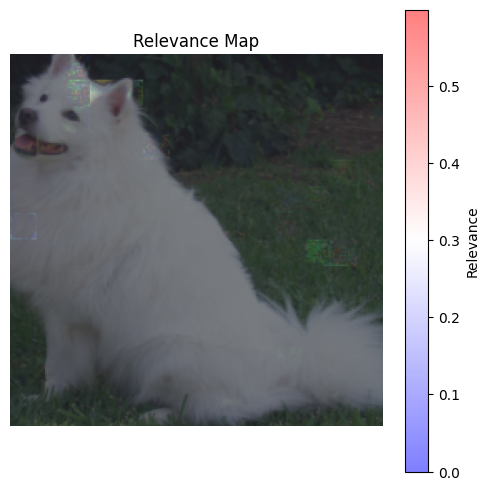

In [95]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_relevance(image, relevance, title="Relevance Map"):
    """
    Plots the relevance map overlayed on the image.
    
    Args:
        image (torch.Tensor or np.ndarray): Input image, shape (C, H, W) or (H, W, C)
        relevance (torch.Tensor or np.ndarray): Relevance scores, same spatial shape as image (H, W)
    """
    if isinstance(image, torch.Tensor):
        image = image.detach().cpu().numpy()
    if isinstance(relevance, torch.Tensor):
        relevance = relevance.detach().cpu().numpy()

    # Handle channel ordering
    if image.shape[0] == 3:
        image = np.transpose(image, (1, 2, 0))
    
    # Normalize image to [0, 1]
    image = (image - image.min()) / (image.max() - image.min() + 1e-8)

    # Normalize relevance around zero
    rel_max = np.abs(relevance).max()
    relevance_norm = relevance / (rel_max + 1e-8)

    plt.figure(figsize=(6, 6))
    plt.imshow(image, alpha=0.8)
    plt.imshow(relevance_norm, cmap='bwr', alpha=0.5)  # 'bwr' = blue-white-red
    plt.colorbar(label='Relevance')
    plt.title(title)
    plt.axis('off')
    plt.show()


plot_relevance(data.squeeze(0), R_in.squeeze(0).permute(1,2,0))


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9950548..0.9463962].


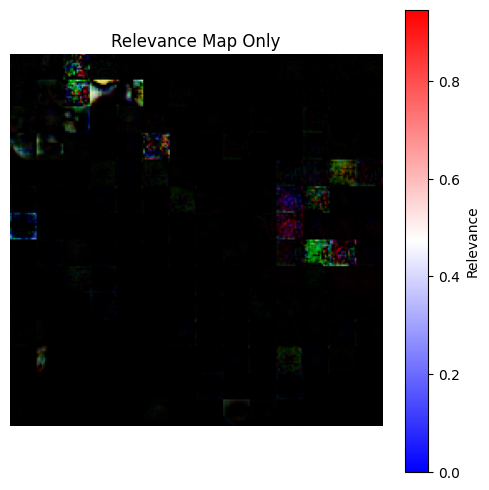

In [96]:
import torch
import matplotlib.pyplot as plt
import numpy as np

def plot_relevance_map(relevance, title="Relevance Map Only", amplify=3.0):
    """
    Plots the standalone relevance map (no image overlap),
    with amplified color contrast for visibility.
    
    Args:
        relevance (torch.Tensor or np.ndarray): Relevance scores, shape (H, W)
        title (str): Title of the plot
        amplify (float): Factor to amplify positive/negative values
    """
    if isinstance(relevance, torch.Tensor):
        relevance = relevance.detach().cpu().numpy()

    # Normalize around zero
    rel_max = np.abs(relevance).max()
    relevance_norm = relevance / (rel_max + 1e-8)

    # Amplify contrast
    relevance_amp = np.tanh(amplify * relevance_norm)  # smooth amplification

    plt.figure(figsize=(6, 6))
    plt.imshow(relevance_amp, cmap='bwr')  # blue-white-red
    plt.colorbar(label='Relevance')
    plt.title(title)
    plt.axis('off')
    plt.show()

# Example usage:
plot_relevance_map(R_in.squeeze(0).permute(1,2,0))


In [67]:
modules[-6].block.attn.norm

Identity()

In [149]:
t = torch.randn(1, 197, 768)

In [151]:
o = (t @ modules[-6].block.attn.qkv.weight.T)

In [154]:
c = o[:,:,2*768:]

In [155]:
c == (t @ modules[-6].block.attn.qkv.weight.T[:, 2*768:])

tensor([[[True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         ...,
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True],
         [True, True, True,  ..., True, True, True]]])

In [ ]:
modules[-6].fc1

AttributeError: 'linear_fn' object has no attribute 'bias'